# Desenvolvimento de conversao arquivo p05 para netcdf
Este é um esqueleto para processamento dos arquivos csv/txt das plataformas, e conversão para netcdf, assim como preenchimento dos dados de informações (metadados). Os passos são os seguintes:
1. Abre arquivo JSON onde informações de configuração, da plataforma e dos arquivo netcdf estão armazenadas. Isso é necessário para flexibilizar o código e permitir reutilizacao do código. Isso é vantajoso quando várias estações com mesmo modelo de arquivo de saída são utilizadas.
2. Abertura do arquivo de imagem e conversão para base64. O arquivo netcdf não tem um tipo de variável adequado para armazenamento direto de arquivos binários. Ainda não esta fechado a melhor forma de armazenar esse tipo de dado dentro do netcdf, mas acho que converter o arquivo para baser64 (texto, muito utilizado em navegadores de internet) é um método razoavel. A vantagem dessa conversão é permitr armazenar os arquivos como texto simples, e fácil de recuperar. Esse formato ainda pode ser revisto.
3. Leitura do arquivo de dados, e varredura para alguns termos para confirmar que arquivo é da estação definida. Leitura das medidas em uma tabela Pandas
4. Criação do arquivo netcdf
5. Geração de metadados
6. Inserção dos dados no arquivo netcdf
7. Dump do arquivo para verificação
8. Verificação do padrão CF

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import os

%matplotlib inline
import matplotlib.pyplot as plt

from netCDF4 import Dataset,num2date, date2num
from datetime import timezone, timedelta


from netCDF4 import Dataset,num2date, date2num, stringtoarr
import json

from gbdhidro import utilconversor
from gbdhidro import utilcf
from gbdhidro.netcdfjson import NetCDFJSON

#from netcdfjson import NetCDFJSON
#import utilconversor
#import utilcf

import base64
from PIL import Image
from io import BytesIO

In [2]:
FILE_PATH = 'p05.csv'
OUTPUT_FOLDER = '.'
JSON_FILE = 'p05.json'
# Abre arquivo json de configuração
with open(JSON_FILE, 'r') as fp:
    json_data = json.load(fp)

In [3]:
json_data['station']

{'name': 'p05',
 'latitude': -31.4761,
 'longitude': -52.6744,
 'altitude': 300.0,
 'image': 'p05.jpg',
 'name_match_string': 'EH-P05',
 'datetime_match_string': ['date', 'time'],
 'precipitation_match_string': ['acum', 'chuva', 'mm'],
 'input_file_encoding': 'utf-8',
 'decimal_separator': '.',
 'column_delimiter': ','}

In [4]:
# Nome do arquivo de dados
STATION_NAME = json_data['station']['name']
# String com identificador utilizado para certificar que eh
# o arquivo da estao escolhida
STATION_ID = json_data['station']['name_match_string']
LATITUDE = json_data['station']['latitude']
LONGITUDE = json_data['station']['longitude']
ALTITUDE = json_data['station']['altitude']
IMAGE_FILE = json_data['station']['image']
DATETIME_MATCH = json_data['station']['datetime_match_string']
PRECIPITATION_MATCH = json_data['station']['precipitation_match_string']



# Seleciona encoding do arquivo
ENCODING = json_data['station']['input_file_encoding']
DECIMAL = json_data['station']['decimal_separator']
SEPARATOR = json_data['station']['column_delimiter']

In [5]:
# Le arquivo de imagem
with open(IMAGE_FILE, "rb") as image_file:
    image_base64 = utilcf.bin2base64(image_file.read())

In [6]:
fo = open(FILE_PATH, "r")
first_line = fo.readline()

In [7]:
first_line

'\ufeff"Plot Title: EH-P05"\n'

In [8]:
# Tenta encontrar 'plot title' na primeira linha para verificar se eh
# arquivo no formato esperado
if utilconversor.find_matches(first_line,[STATION_ID]):
    print('Processando estacao ID: ' + STATION_ID)
else:
    print("Erro: não é arquivo da estacao" + STATION_ID)
    

Processando estacao ID: EH-P05


In [9]:
# Extrai dados da aquisicao
table = pd.read_csv(fo, sep=SEPARATOR, skiprows=0, verbose=False, na_filter=True,  header=0, encoding=ENCODING, decimal=DECIMAL, warn_bad_lines=True)
fo.close()
table

,#,"Date Time, GMT-03:00","Soma Acum.: Chuva, mm (LGR S/N: 10364364)",Coupler Attached (LGR S/N: 10364364),Host Connected (LGR S/N: 10364364),Stopped (LGR S/N: 10364364),End Of File (LGR S/N: 10364364)
0,1,03/28/19 11:00:00 AM,0.0,NaN,NaN,NaN,NaN
1,2,03/28/19 11:05:00 AM,0.0,NaN,NaN,NaN,NaN
2,3,03/28/19 11:10:00 AM,0.0,NaN,NaN,NaN,NaN
3,4,03/28/19 11:15:00 AM,0.0,NaN,NaN,NaN,NaN
4,5,03/28/19 11:20:00 AM,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
21309,21310,06/10/19 10:45:00 AM,0.0,NaN,NaN,NaN,NaN
21310,21311,06/10/19 10:46:25 AM,NaN,Logged,NaN,NaN,NaN
21311,21312,06/10/19 10:46:28 AM,NaN,NaN,Logged,NaN,NaN
21312,21313,06/10/19 10:46:38 AM,NaN,NaN,Logged,NaN,NaN


In [10]:
# Procura por coluna de datetime e variavel
date_time_col = None
precipitation_col = None
for column in table.columns:
    if utilconversor.find_matches(column,['date', 'time']):
        date_time_col = column
    if utilconversor.find_matches(column,['acum', 'chuva', 'mm']):
        precipitation_col = column

if date_time_col is None:
    print('Error, nao foi encontrada coluna de data')
else:
    print('Coluna datetime: ' + date_time_col)

if precipitation_col is None:
    print('Error, nao foi encontrada coluna de precipitacao')
else:
    print('Coluna precipitacao: ' + precipitation_col)

Coluna datetime: Date Time, GMT-03:00
Coluna precipitacao: Soma Acum.: Chuva, mm (LGR S/N: 10364364)


In [11]:
# Processa datetime para incluir timezone
date_str = table[date_time_col]
date_time = pd.to_datetime(date_str, format='%m/%d/%y %I:%M:%S %p')
# extrai informacao de gmt
gmt_hour_offset, gmt_minute_offset = utilconversor.get_gmt_offset(date_time.name)
tzinfo=timezone(timedelta(hours=gmt_hour_offset, minutes=gmt_minute_offset))
# gera os indices com informacao de fuso horarios incluido
index = date_time.dt.tz_localize(tzinfo)
# converte para UTC
index_utc = index.dt.tz_convert('UTC')
first_day_str = utilcf.datetime2str(index_utc.iloc[0])
last_day_str = utilcf.datetime2str(index_utc.iloc[-1])
print("Inicio e fim de medidas em UTC: {} - {}".format(first_day_str, last_day_str))

Inicio e fim de medidas em UTC: 20190328T140000Z - 20190610T134712Z


In [12]:
# Encontra coluna com chuva
precipitation = table[precipitation_col]
precipitation

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21309    0.0
21310    NaN
21311    NaN
21312    NaN
21313    NaN
Name: Soma Acum.: Chuva, mm (LGR S/N: 10364364), Length: 21314, dtype: float64

In [13]:
# Gera nome de arquivo de saida
file_name = '{}_{}_{}.nc'.format(STATION_NAME, first_day_str, last_day_str)
print("Nome de arquivo de saida: {}".format(file_name))

Nome de arquivo de saida: p05_20190328T140000Z_20190610T134712Z.nc


## Geracao de arquivo netCDF

In [14]:
nc_file_path = os.path.join(OUTPUT_FOLDER, file_name)
# Cria arquivo netCDF
nc_file = NetCDFJSON()
nc_file.write(nc_file_path)
# Le arquivo json com configuracao da estrutura do netcdf
nc_file.load_json('p05.json')
nc_file.create_from_json()

# pega handlers para dimensoes
timeDim = nc_file.get_dimension('time')
nameDim = nc_file.get_dimension('name_strlen')
# pega handlers para variaveis
time = nc_file.get_variable('time')
time_bnds = nc_file.get_variable('time_bnds')
lat = nc_file.get_variable('lat')
lon = nc_file.get_variable('lon')
alt = nc_file.get_variable('alt')
station_name = nc_file.get_variable('station_name')
precip = nc_file.get_variable('precipitation')
station_image = nc_file.get_variable('station_image')

# Recupera qual o valor uilizado para valores que estao faltando
FILL_VALUE = precip._FillValue

In [15]:
# Substitui Nan por FILL_VALUE
precipitation = precipitation.replace(np.nan, FILL_VALUE)

# Seta variaveis
nc_time = index_utc.to_numpy()
nc_time = date2num(nc_time,units=time.units,calendar=time.calendar)
# Como a precipitacao e o acumulado entre a ultima medida e a atual
# é necessario informar isso atraves dos bounds de tempo, ou seja,
# os valores inferioes e superiores respectivos ao limite do eixo de temp0
# O bound superior e o mesmo que o horario da medids
nc_superior_bound_time = nc_time
# bound inferior e o horario da ultima medida
nc_inferior_bound_time = np.roll(nc_superior_bound_time,1)
# a primeira medida não tem medida anterior, por isso seta para o mesmo valor
nc_inferior_bound_time[0] = nc_superior_bound_time[0]
# combina bound inferior com bound superior
bnds = np.stack((nc_inferior_bound_time, nc_superior_bound_time), axis=-1)

nc_serie = precipitation.to_numpy()

nc_station_name = STATION_NAME
latitude = LATITUDE
longitude = LONGITUDE
altitude = ALTITUDE

lat[:] = np.array([latitude])
lon[:] = np.array([longitude])
alt[:] = np.array([altitude])

time[:] = nc_time
time_bnds[:] = bnds

precip[:] = np.array(nc_serie)

station_name[:] = stringtoarr(nc_station_name, nameDim.size)
station_image[:] = stringtoarr(image_base64, len(image_base64))
station_image.file_name = IMAGE_FILE

In [16]:
# Faz processamento para metadados
# Processa os dados ja convertidos para facilitar reutilizar o codigo depois

# min max lat e lon
min_lat = np.amin(lat)
max_lat = np.amax(lat)
min_lon = np.amin(lon)
max_lon = np.amax(lon)

# time duration
min_time = num2date(np.amin(time), units=time.units, calendar=time.calendar)
max_time = num2date(np.amax(time), units=time.units, calendar=time.calendar)
min_time_str = utilcf.datetime2str(min_time)
max_time_str = utilcf.datetime2str(max_time)
time_delta = max_time - min_time
time_delta_str = utilcf.timedelta2str(time_delta)

# time resolution
time1 = num2date(time[1], units=time.units, calendar=time.calendar)
time0 = num2date(time[0], units=time.units, calendar=time.calendar)
time_resolution = time1 - time0
time_resolution_str = utilcf.timedelta2str(time_resolution)


print('Min/Max latitude: {}/{}'.format(min_lat,max_lat))
print('Min/Max longitude: {}/{}'.format(min_lon,max_lon))
print('Min/Max datetime: {}/{}'.format(min_time_str,max_time_str))
print('Time duration:{}'.format(time_delta_str))
print('Time resolution:{}'.format(time_resolution_str))


Min/Max latitude: -31.47610092163086/-31.47610092163086
Min/Max longitude: -52.674400329589844/-52.674400329589844
Min/Max datetime: 20190328T140000Z/20190610T134712Z
Time duration:P73DT23H47M12S
Time resolution:PT05MS


In [17]:
# Atualiza metadados
nc_file.rootgrp.geospatial_lat_min = min_lat
nc_file.rootgrp.geospatial_lat_max = max_lat
nc_file.rootgrp.geospatial_lon_min = min_lon
nc_file.rootgrp.geospatial_lon_max = max_lon
nc_file.rootgrp.time_coverage_start = min_time_str
nc_file.rootgrp.time_coverage_end = max_time_str
nc_file.rootgrp.time_coverage_duration = time_delta_str
nc_file.rootgrp.time_coverage_resolution = time_resolution_str
nc_file.rootgrp.id = file_name
nc_file.rootgrp.date_created = utilcf.datetime2str(datetime.now(timezone.utc))

In [18]:
#nc_file.rootgrp

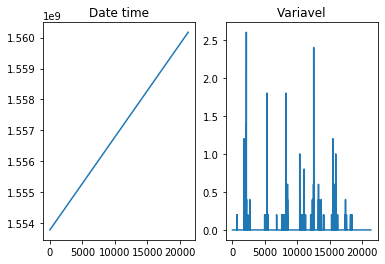

p05.jpg


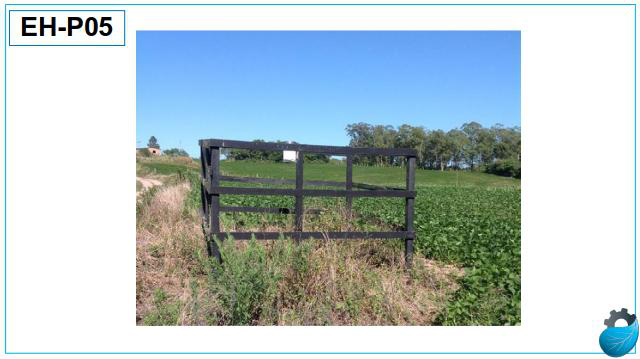

In [19]:
# Visualiza dados para confirma se esta tudo ok.
# Date time deve ser linear, sem quebras abruptas
fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.plot(time[:])
ax0.set_title('Date time')
ax1.plot(precip[:])
ax1.set_title('Variavel')
plt.show() 

# Mostra imagem
image = utilcf.base642bin(station_image[:])
print(station_image.file_name)
Image.open(image)

In [ ]:
# Fecha e salva arquivo
nc_file.close()

## Dump do arquivo nc

In [ ]:
# Apresenta o dump do arquivo netcdf
# Precisa instalar: sudo apt install netcdf-bin 
cmd = '"' + nc_file_path + '"'
!ncdump {  cmd }

## Verifica se arquivo .nc atende o CF Standard

In [ ]:
# Verifica compatibilidade com CF
# Precisa instalar pip install cfchecker 
# site: https://pypi.org/project/cfchecker/
CF_VERSION = '1.7'
cmd = '-v ' + CF_VERSION + ' ' + '"' + nc_file_path + '"'
!cfchecks {cmd}